In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import urllib.request
import os

import matplotlib.pyplot as plt

In [2]:
def get_gwno():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/simon/Documents/Bodies/data/PRIO'#local
    #path_gwno = location + '/PRIO-GRID Yearly Variables for 2003-2009 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno

def get_prio_shape():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/simon/Documents/Bodies/data/PRIO'#local
    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    return prio_grid


def get_gwno():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/simon/Documents/Bodies/data/PRIO' #local
    #path_gwno = location + '/PRIO-GRID Yearly Variables for 2003-2009 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno


def get_ucdp():

    #location = '/home/projects/ku_00017/data/raw/UCDP'
    location = '/home/simon/Documents/Bodies/data/UCDP' #local
    path_ucdp = location + "/ged201-csv.zip"
    
    if os.path.isfile(path_ucdp) == True:
        print('file already downloaded')
        ucdp = pd.read_csv(path_ucdp, low_memory=False)


    else: 
        print('Beginning file download UCDP...')

        url_ucdp = 'https://ucdp.uu.se/downloads/ged/ged201-csv.zip'
    
        urllib.request.urlretrieve(url_ucdp, path_ucdp)
        ucdp = pd.read_csv(path_ucdp, low_memory=False)


    # just to save ram for now !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    sub_years = sorted(ucdp['year'].unique())[:2]
    ucdp = ucdp[ucdp['year'].isin(sub_years)]
    # -----------------------------------------------------------------------------------------------------

    ucdp['month'] = pd.to_datetime(ucdp['date_start']).dt.month
    ucdp.rename(columns= {'priogrid_gid' : 'gid'}, inplace= True)

    feature_list = ['month','year', 'gid', 'deaths_a','deaths_b', 'deaths_civilians', 'deaths_unknown','best', 'high', 'low']

    ucdp_monthly_unit = ucdp.loc[:,feature_list].groupby(['month','year', 'gid']).sum().reset_index()
    ucdp_monthly_unit['log_best'] = np.log(ucdp_monthly_unit['best'] +1)
    ucdp_monthly_unit['log_low'] = np.log(ucdp_monthly_unit['low'] +1)
    ucdp_monthly_unit['log_high'] = np.log(ucdp_monthly_unit['high'] +1)

    ucdp_monthly_unit['in_ucdp'] = True # handy later when I wnat to remove water and stuff.

    return ucdp_monthly_unit


In [3]:
def monthly_grid(prio_grid, ucdp):

    years = [sorted(ucdp['year'].unique())] * prio_grid.shape[0]
    months = [list(np.arange(1, 13))] * prio_grid.shape[0]

    prio_grid['year'] = years
    prio_grid['month'] = months

    prio_grid = prio_grid.explode('year').reset_index(drop=True) 
    prio_grid = prio_grid.explode('month').reset_index(drop=True) 

    prio_grid['year'] = prio_grid['year'].astype(int)
    prio_grid['month'] = prio_grid['month'].astype(int)

    return prio_grid

In [4]:

def make_full_grid(prio_grid, ucdp, gwno):

    prio_grid = prio_grid.merge(gwno, on = ['gid', 'year'], how = 'left') 

    # you can easily add monthly prio features here (if you got the ram for it)

    full_grid = prio_grid.merge(ucdp, on = ['gid', 'year', 'month'], how = 'left') 
    full_grid.fillna({'best' : 0, 'low' : 0, 'high' : 0, 'log_best' : 0, 'log_low' : 0, 'log_high' : 0, 'gwno' : 0}, inplace = True) # for gwno 0 is no country
    full_grid.fillna({'in_ucdp' : False}, inplace = True)

    full_grid['log_best'] = np.log(full_grid['best'] + 1)
    full_grid['log_high'] = np.log(full_grid['high'] + 1)
    full_grid['log_low'] = np.log(full_grid['low'] + 1)

    return full_grid

In [5]:
def add_month_id(prio_grid):

    prio_grid['year_month'] = prio_grid['year'].astype(str) + '_' + prio_grid['month'].astype(str) 

    ts = prio_grid['year_month'].unique()
    n_ts = len(ts)
    month_ids = np.arange(109, n_ts + 109, 1)
    month_id_df = pd.DataFrame({'year_month' : ts, 'month_id': month_ids})
    prio_grid = prio_grid.merge(month_id_df, on = 'year_month', how = 'left')

    return prio_grid

In [6]:
def check_month_id(prio_grid):

    for year in prio_grid['year'].unique():
        print(year, end = ': ')
        print(prio_grid[prio_grid['year'] == year]['month_id'].unique(), end = ': ')
        print(len(prio_grid[prio_grid['year'] == year]['month_id'].unique()))

In [7]:
def make_volumn(df):

    # we start with wat we know - but there is no reason not to try with more down til line.

    sub_df = df[['gid', 'xcoord', 'ycoord', 'month_id', 'best', 'low', 'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col.

    sub_df_sorted = sub_df.sort_values(['month_id', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = sub_df['xcoord'].unique().shape[0]
    y_dim = sub_df['ycoord'].unique().shape[0]
    z_dim = sub_df['month_id'].unique().shape[0]

    ucpd_vol = np.array(sub_df_sorted).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol

In [8]:
prio_grid = get_prio_shape()
gwno = get_gwno()
ucdp = get_ucdp()
prio_grid = monthly_grid(prio_grid, ucdp)
prio_grid = make_full_grid(prio_grid, ucdp, gwno)
prio_grid = add_month_id(prio_grid)
print(prio_grid.shape)


File already downloaded
file already downloaded
(6220800, 21)


In [9]:
check_month_id(prio_grid)

1989: [109 110 111 112 113 114 115 116 117 118 119 120]: 12
1990: [121 122 123 124 125 126 127 128 129 130 131 132]: 12


In [10]:
ucpd_vol = make_volumn(prio_grid)
print(ucpd_vol.shape)

(24, 360, 720, 10)


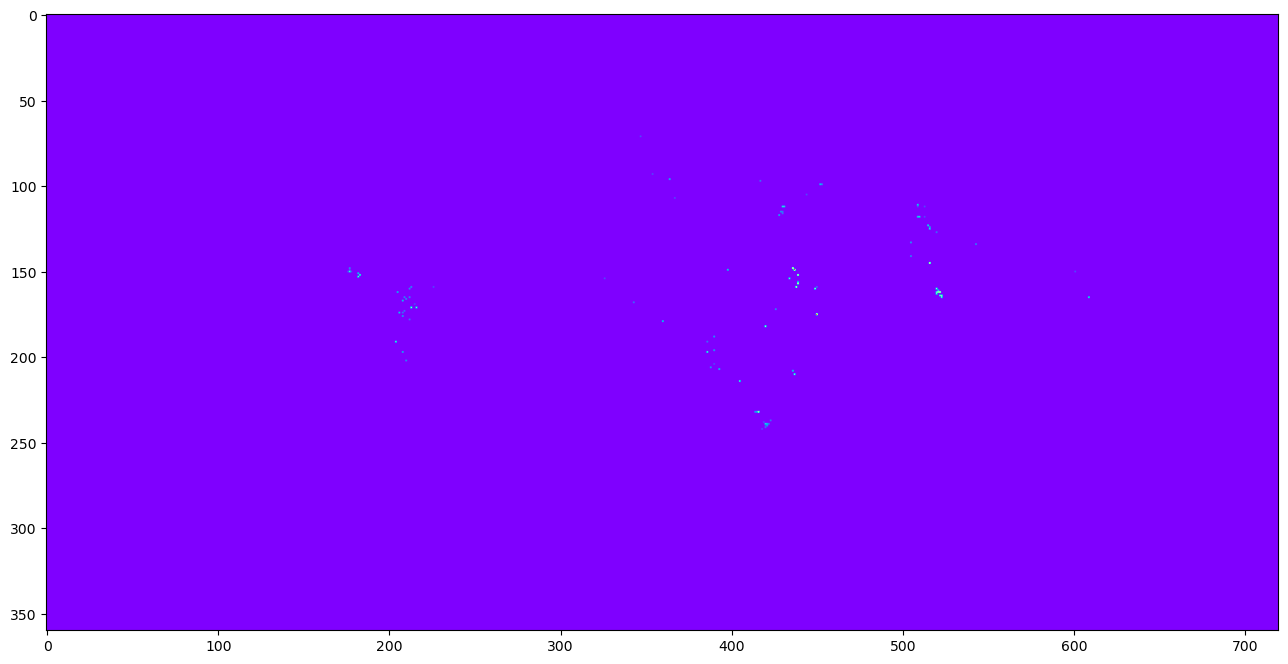

In [11]:
plt.figure(figsize= [20,8])
plt.imshow(ucpd_vol[-1,:,:,7], cmap = 'rainbow', vmin=ucpd_vol[-1,:,:,7].min() , vmax=ucpd_vol[-1,:,:,7].max())
plt.show()

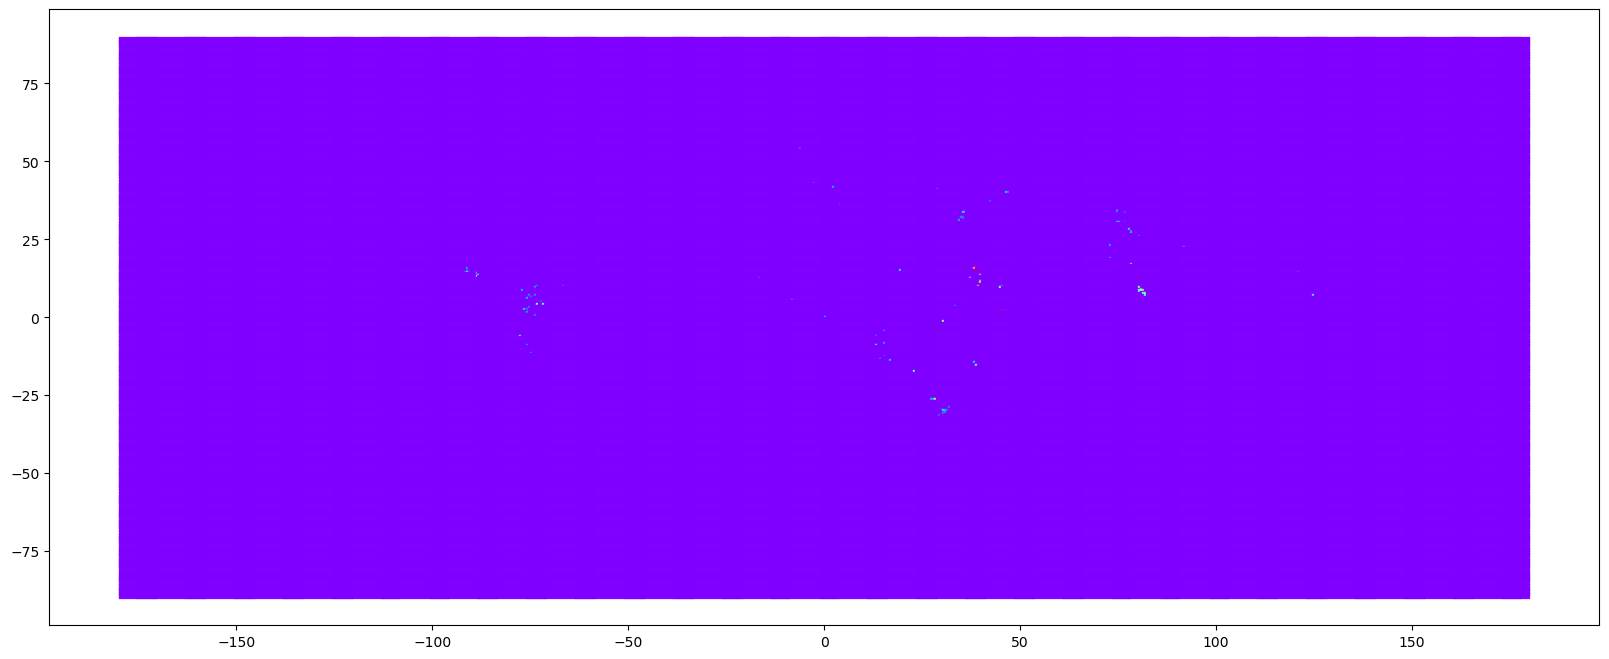

In [12]:
#mask = (prio_grid['month_id'] == 132) & (prio_grid['gwno'] != 0)
mask = prio_grid['month_id'] == 132

sub_grid = prio_grid[mask]

x = sub_grid['xcoord']
y = sub_grid['ycoord']
z = sub_grid['log_best']

plt.figure(figsize= [20,8])
plt.scatter(x, y, c = z, marker= 's', s = 1, cmap = 'rainbow', vmin=z.min(), vmax=z.max() )
plt.show()

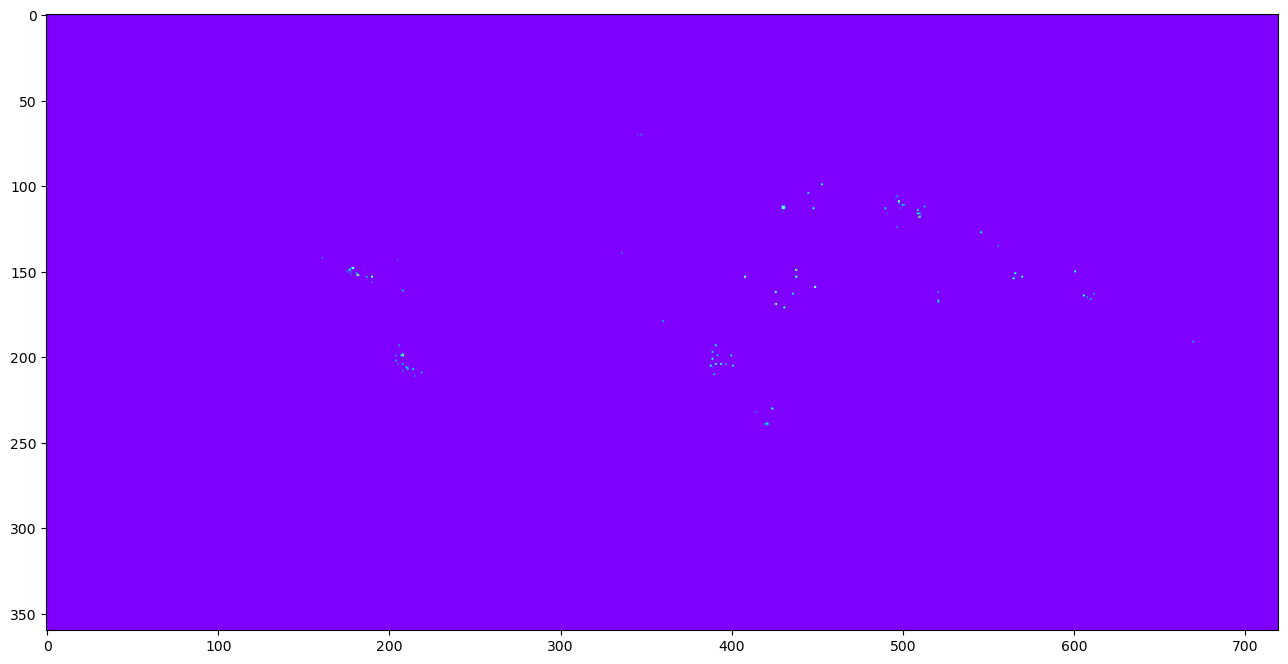

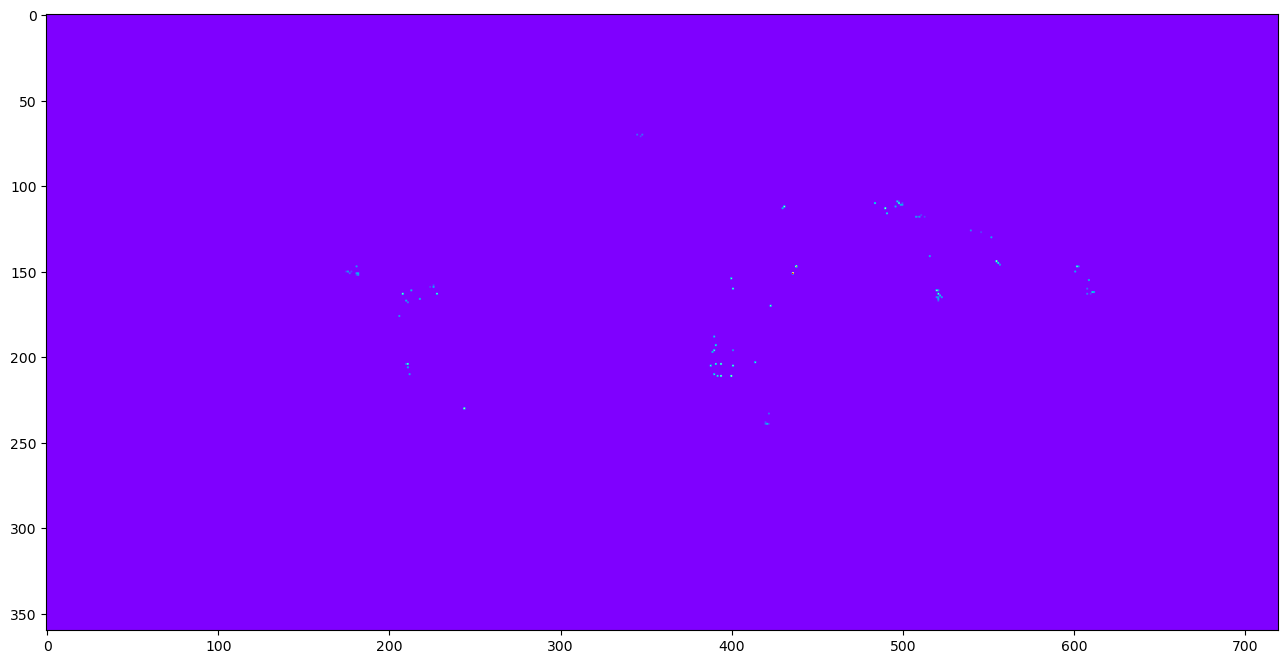

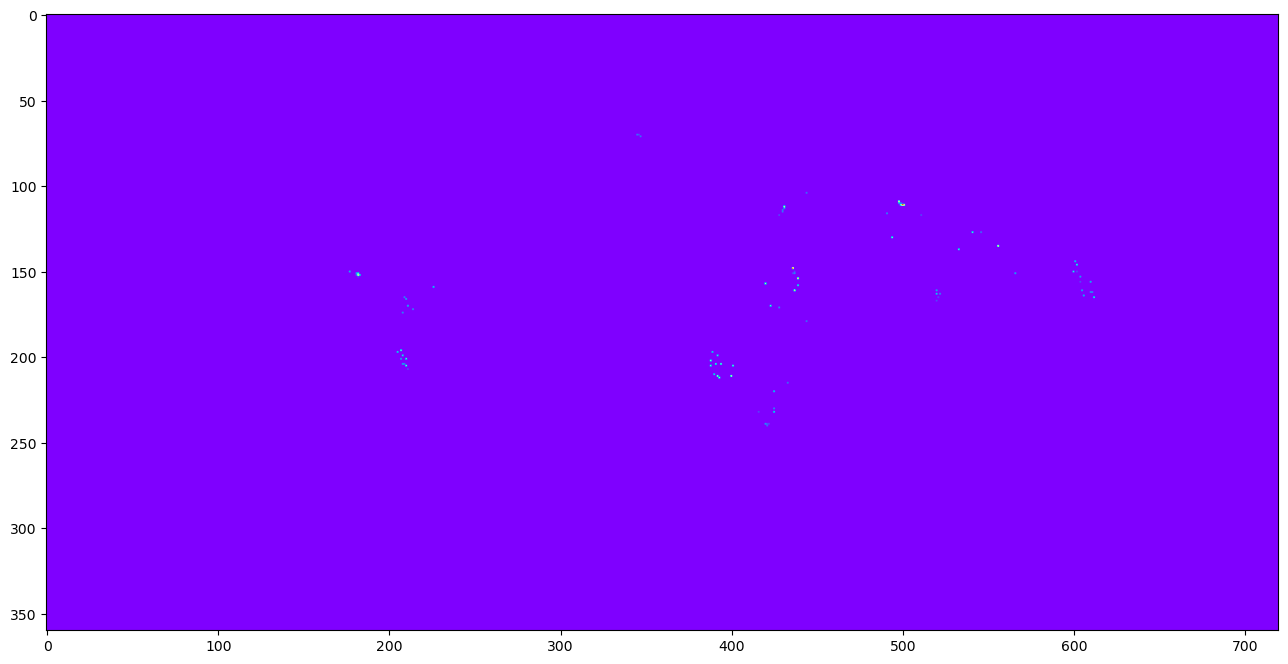

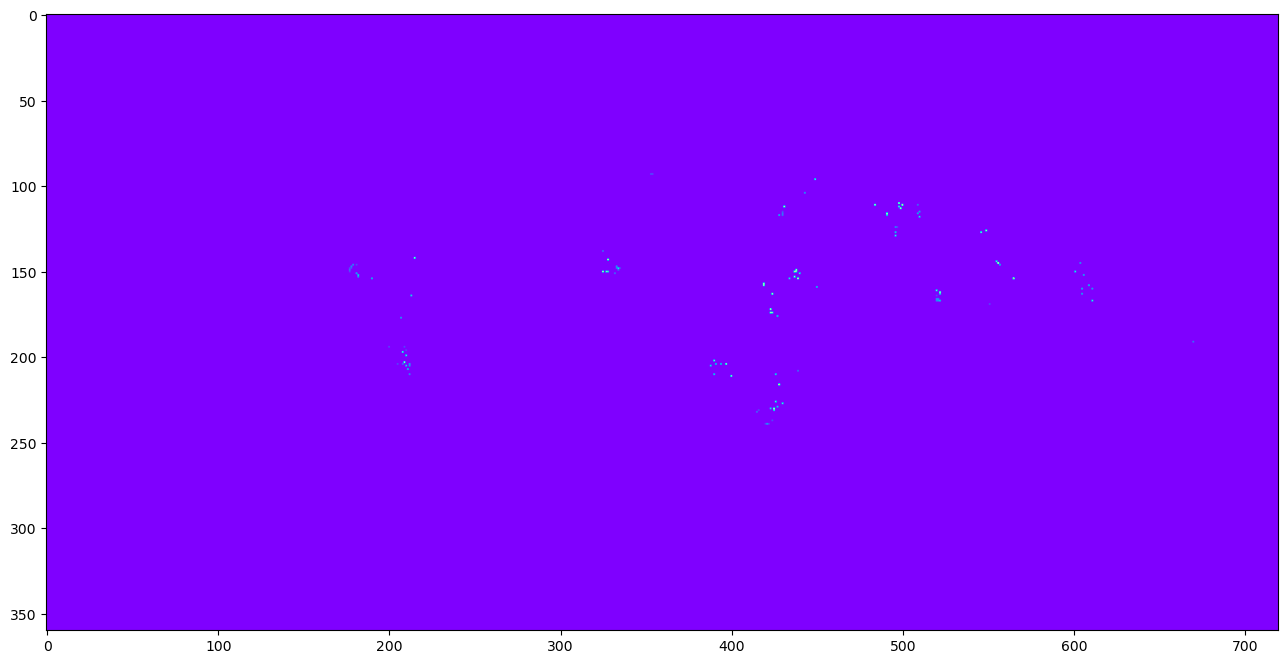

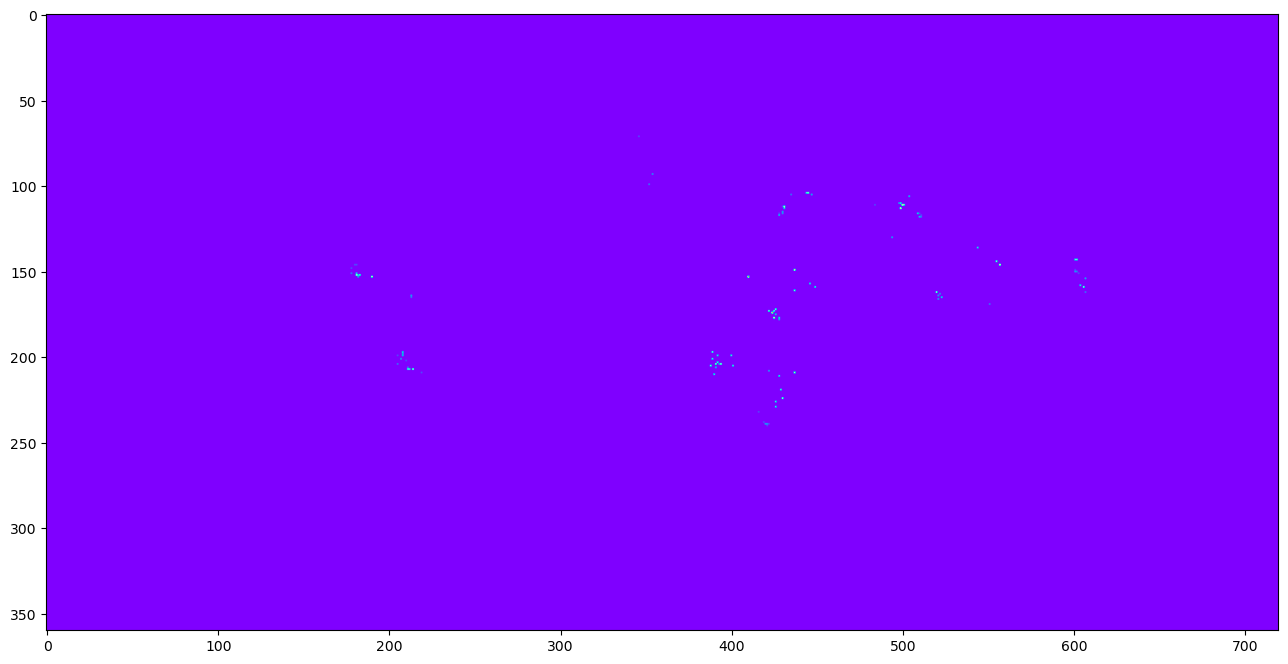

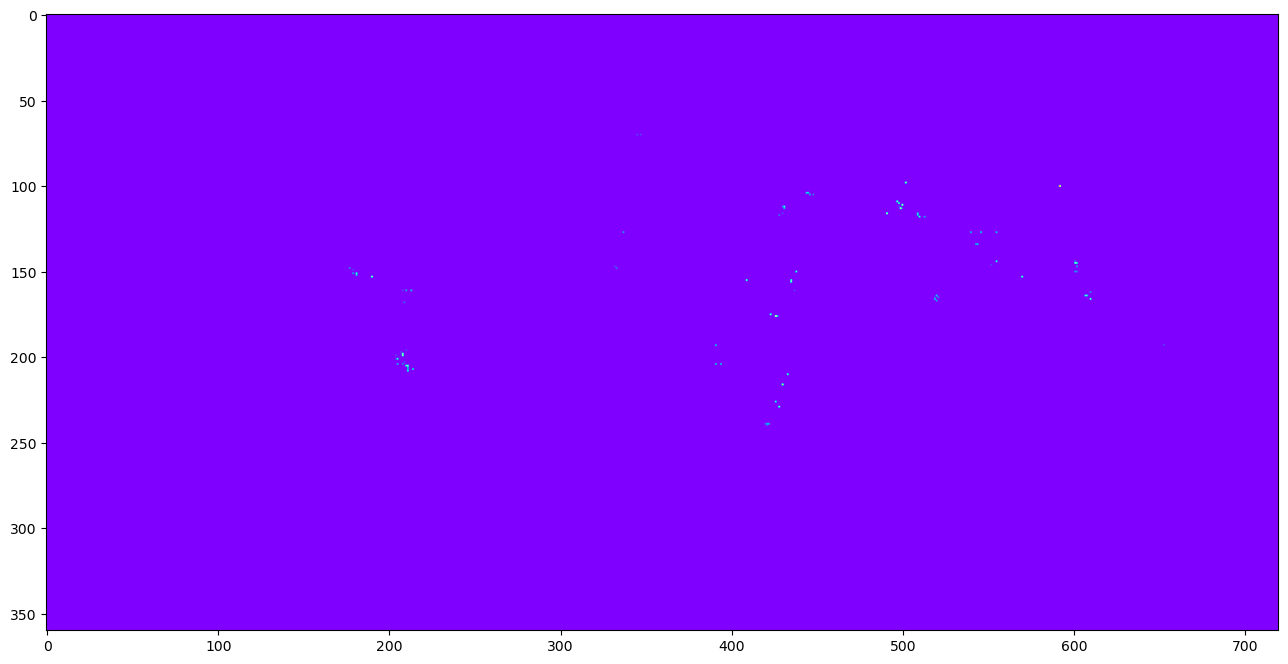

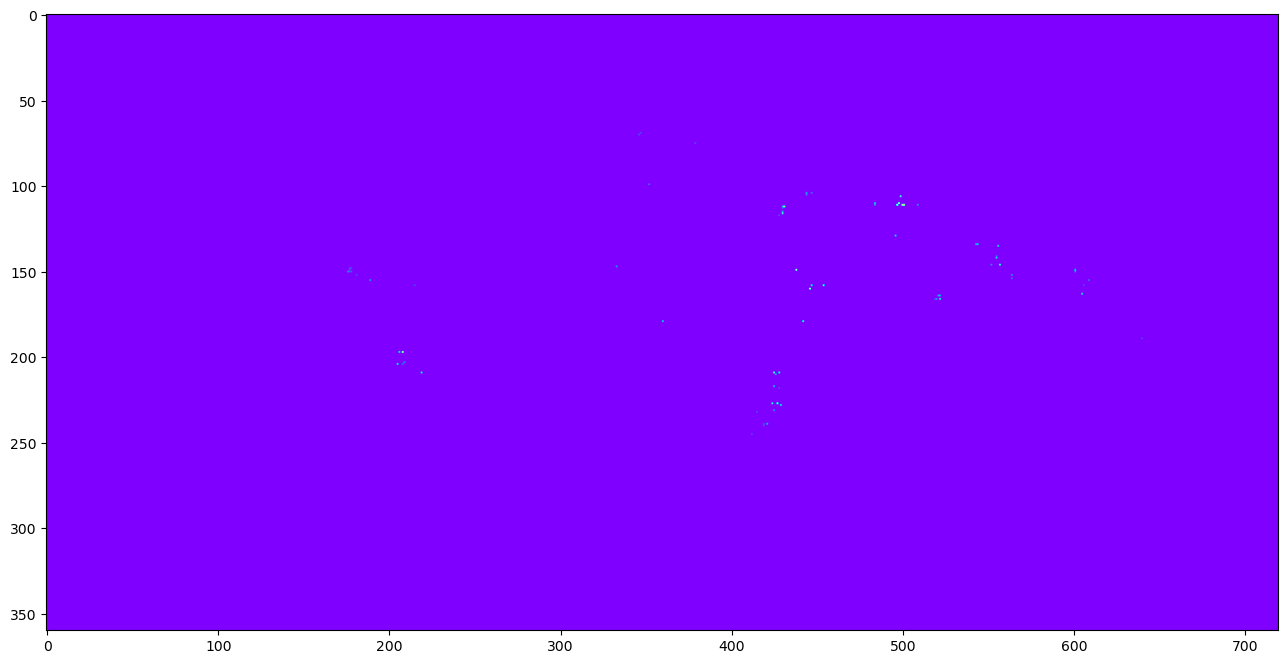

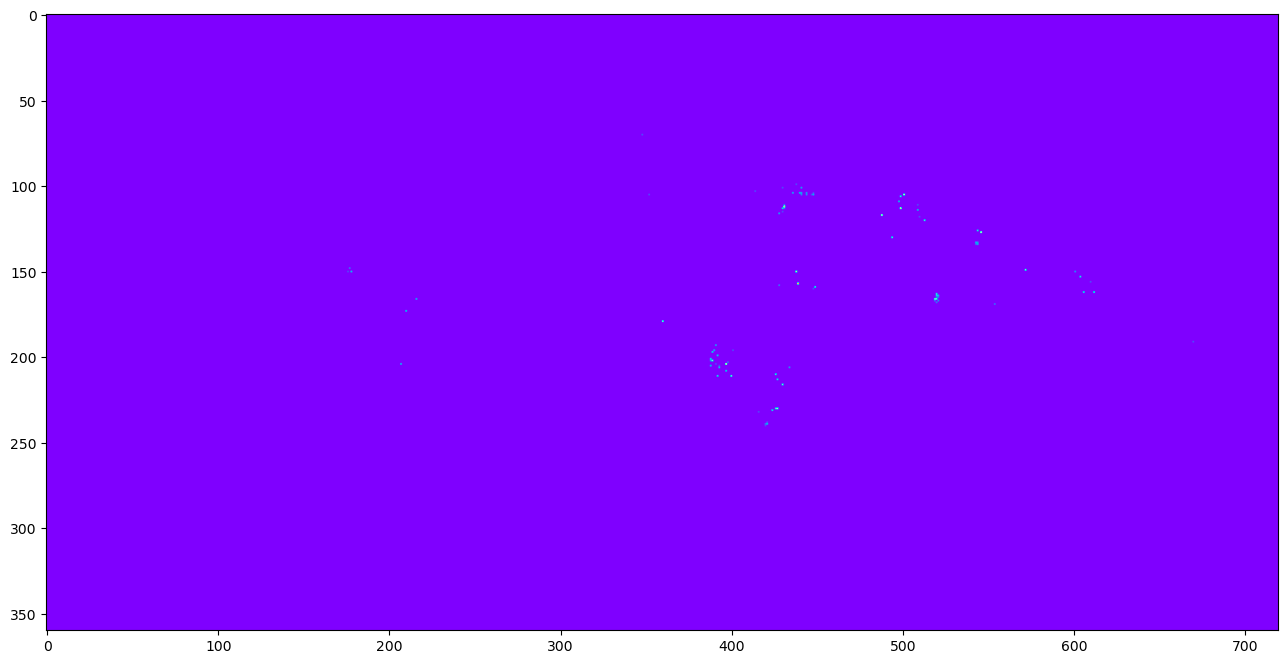

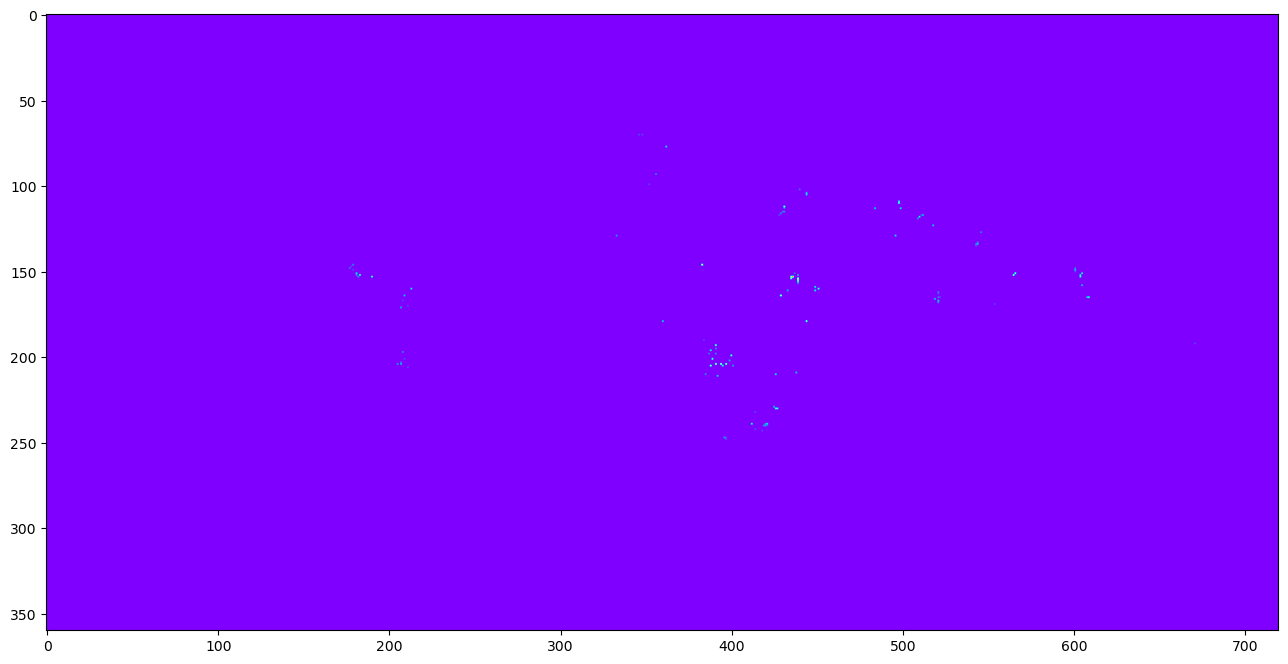

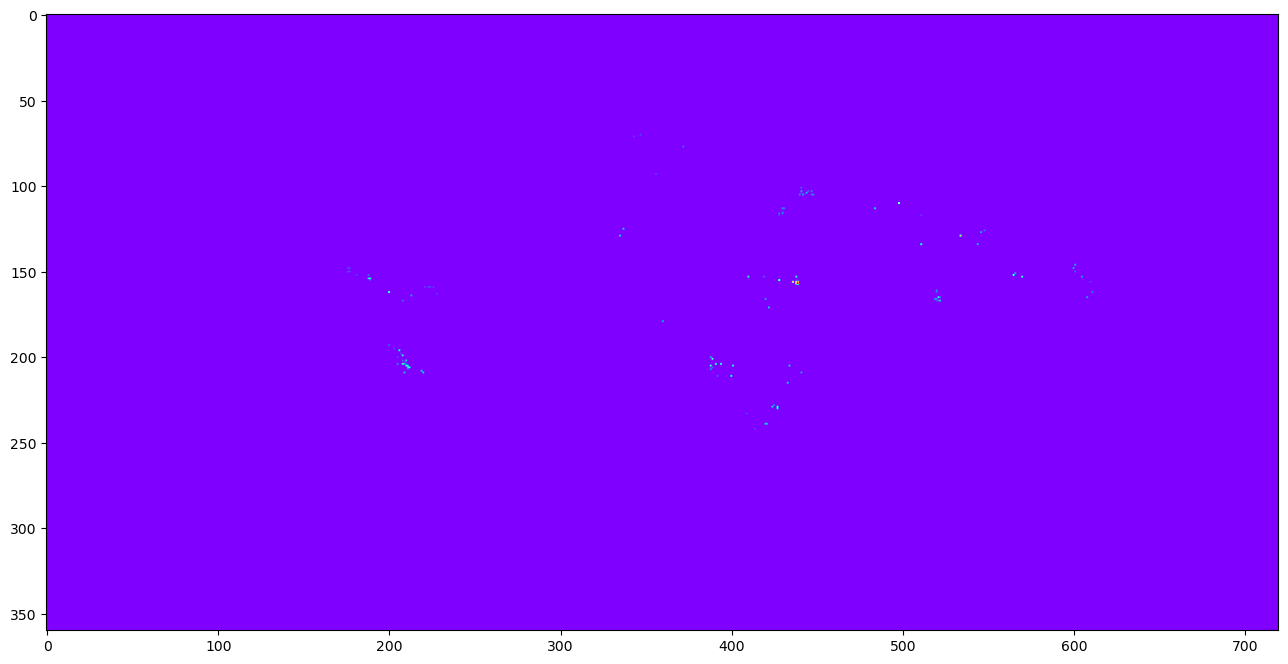

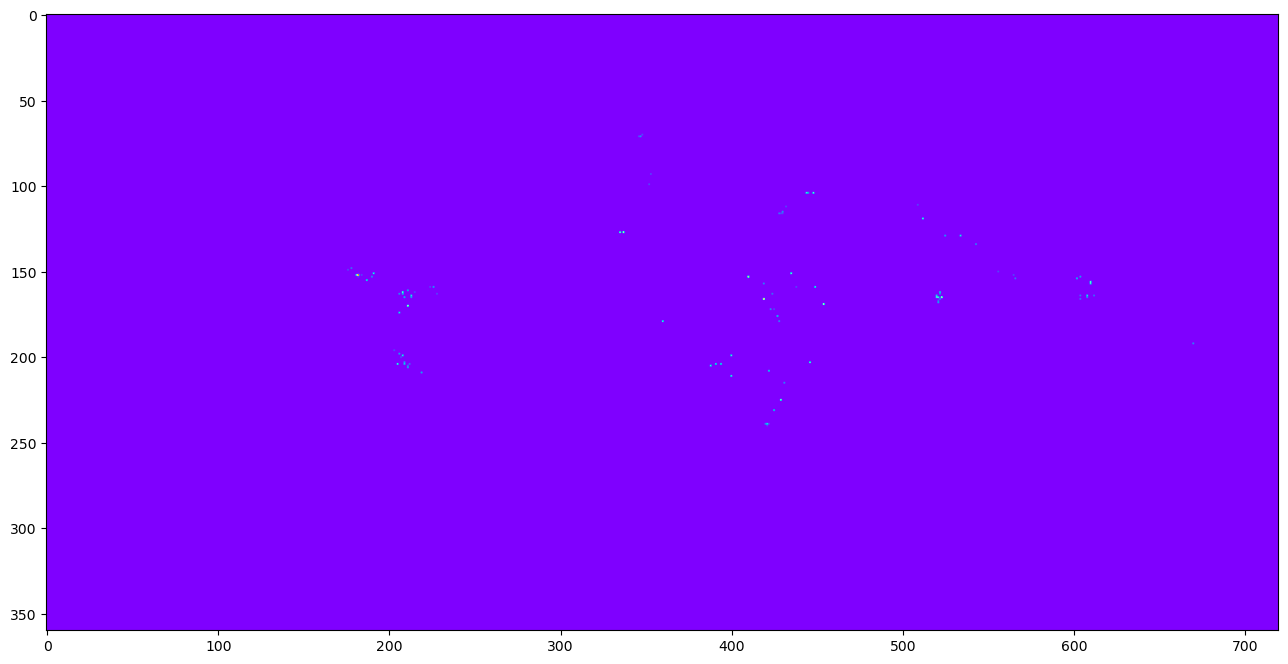

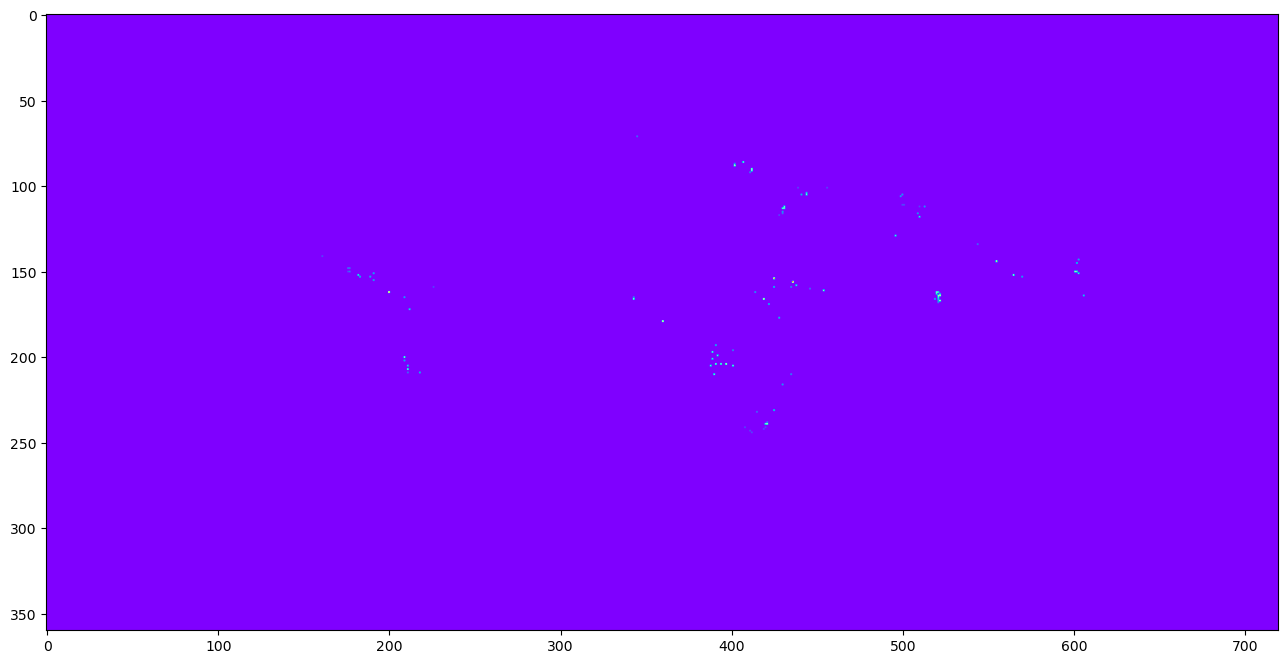

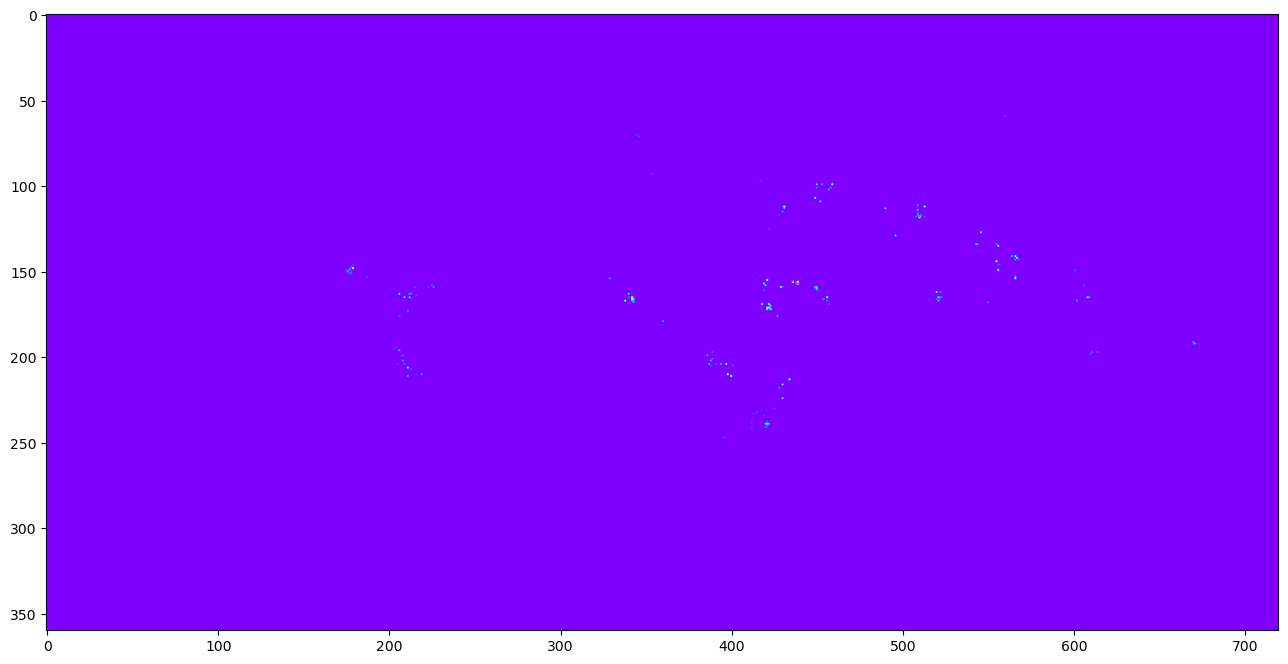

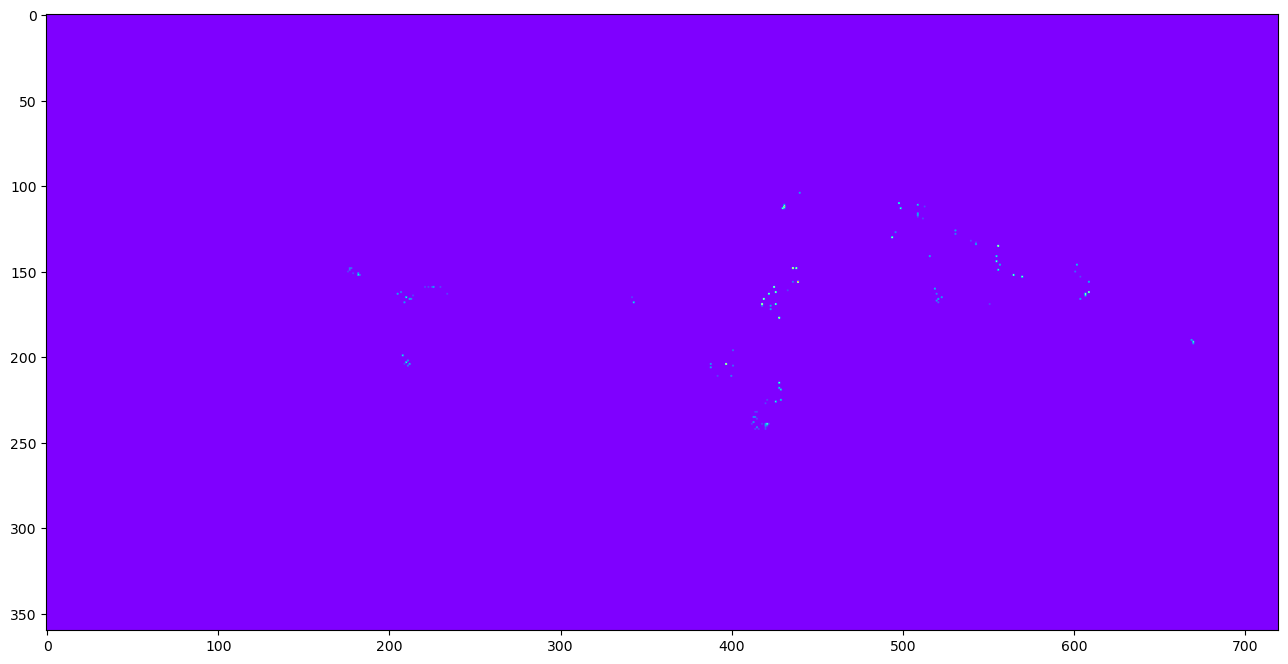

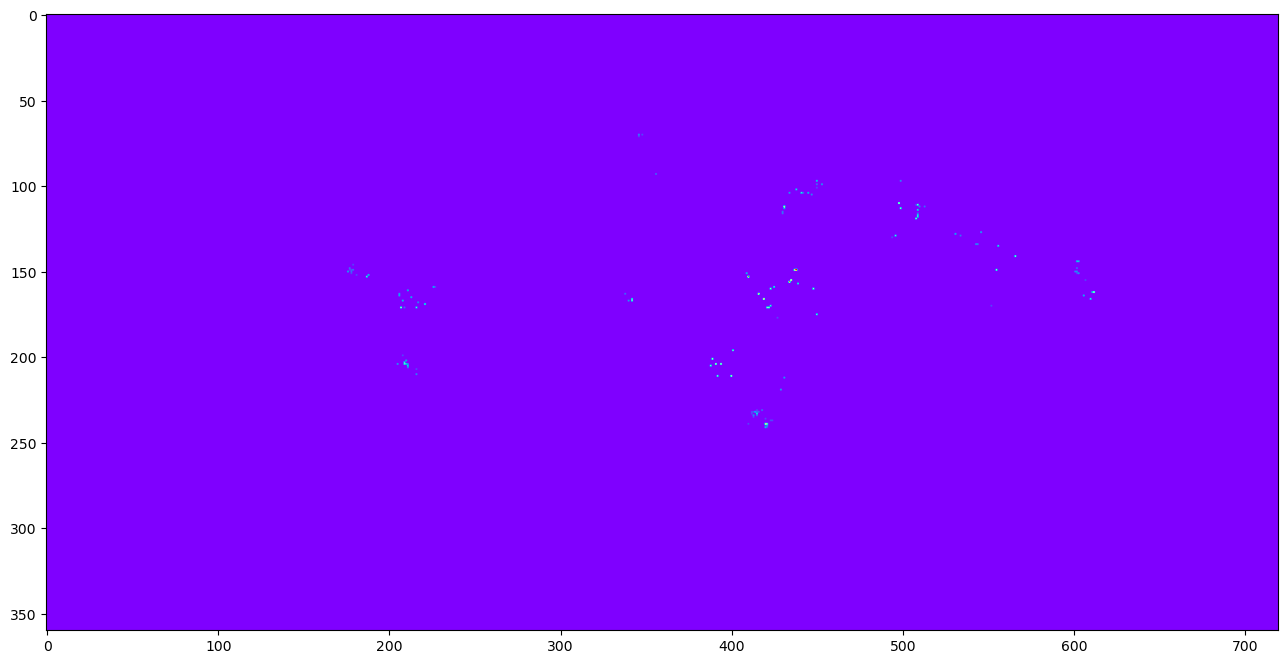

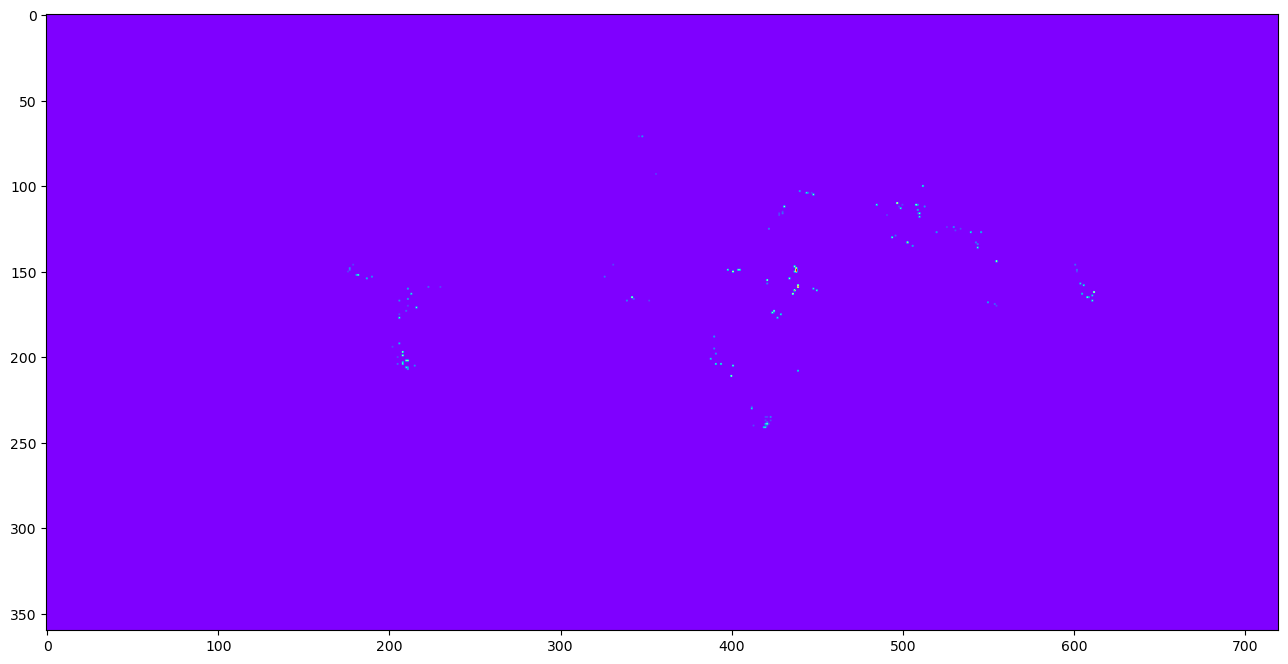

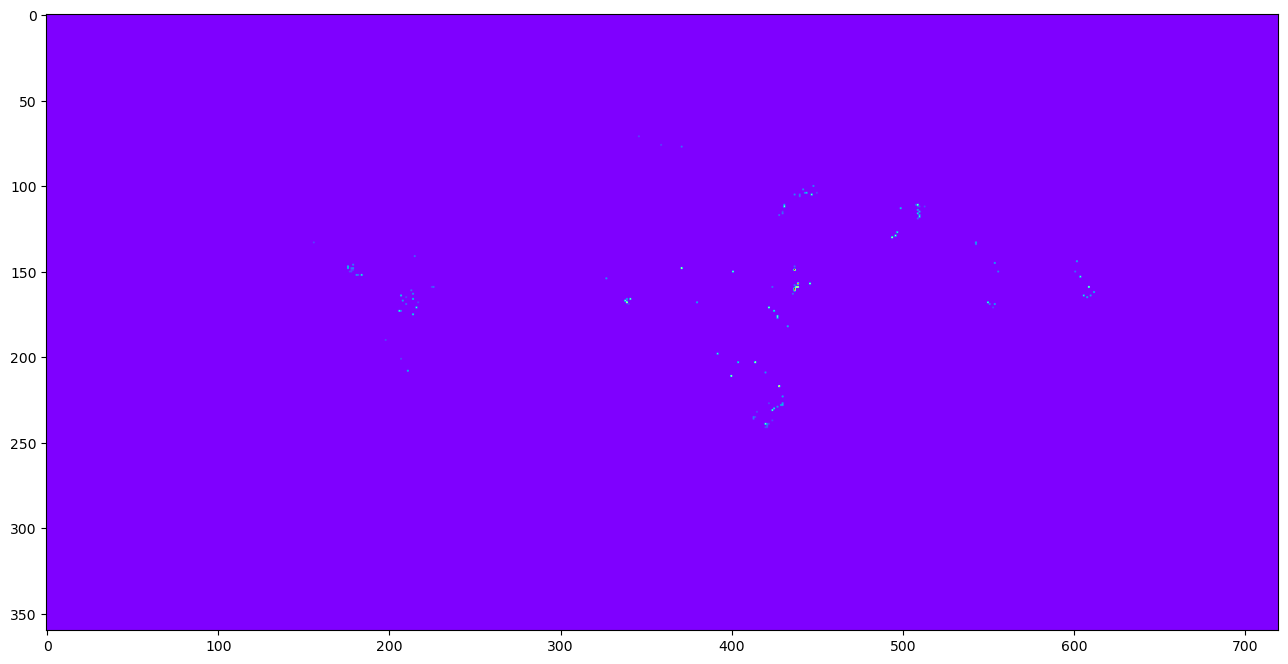

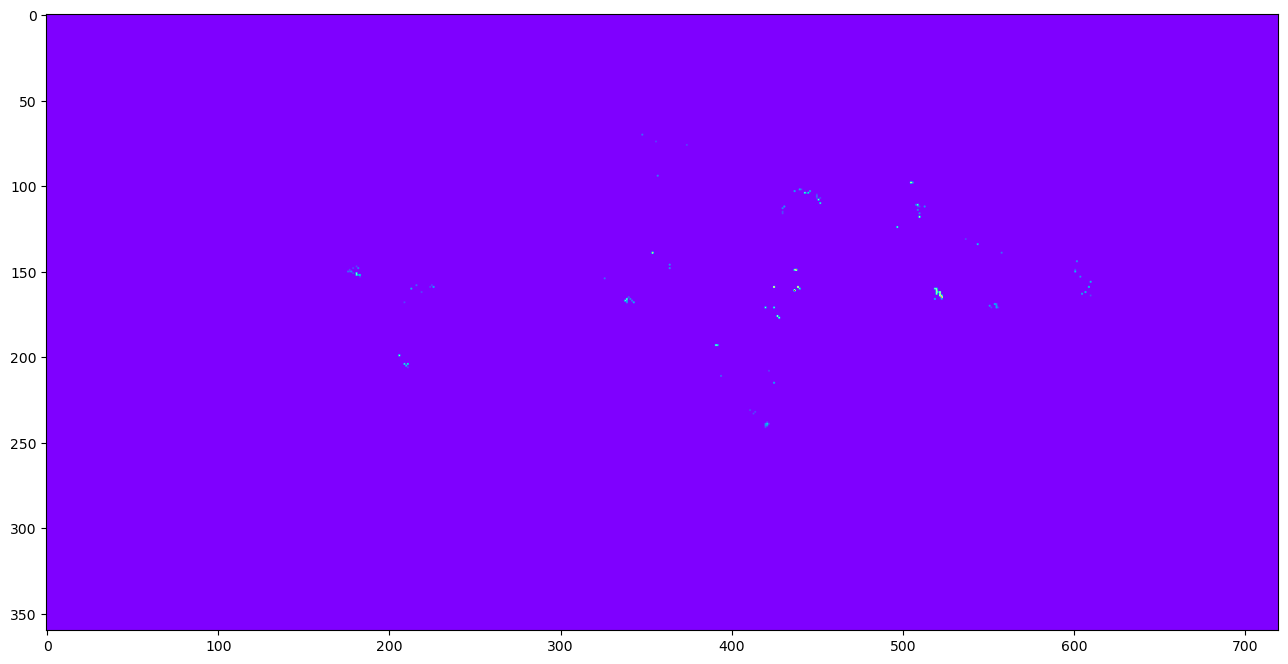

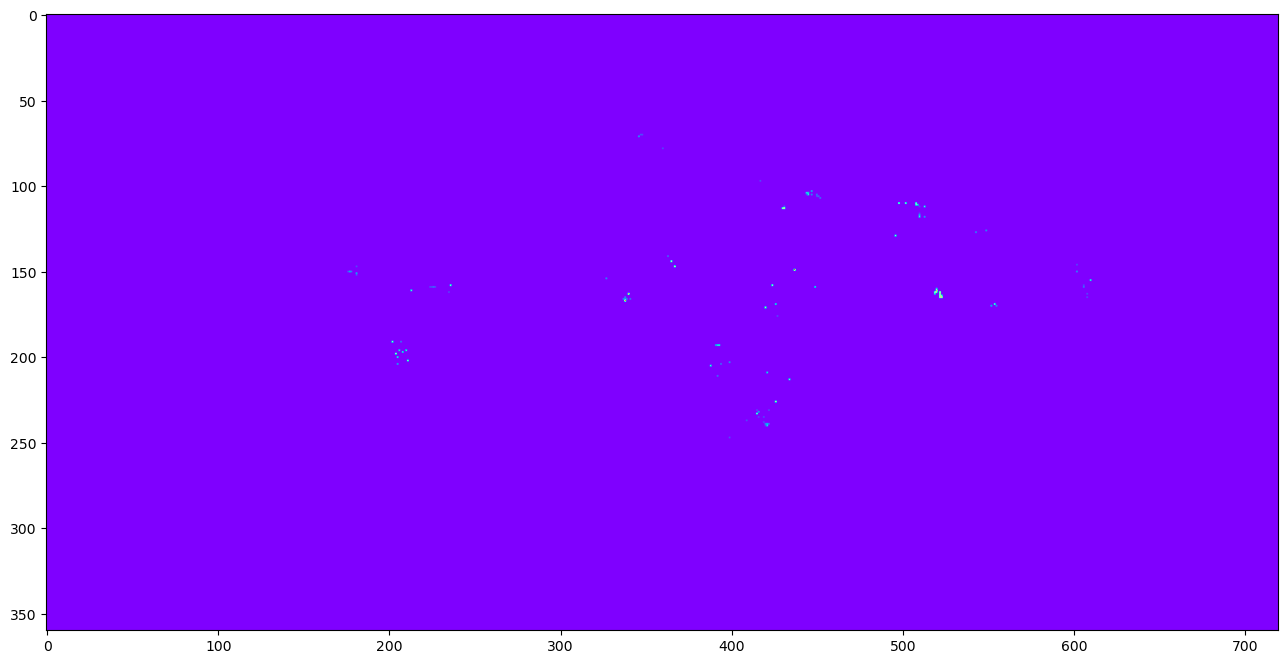

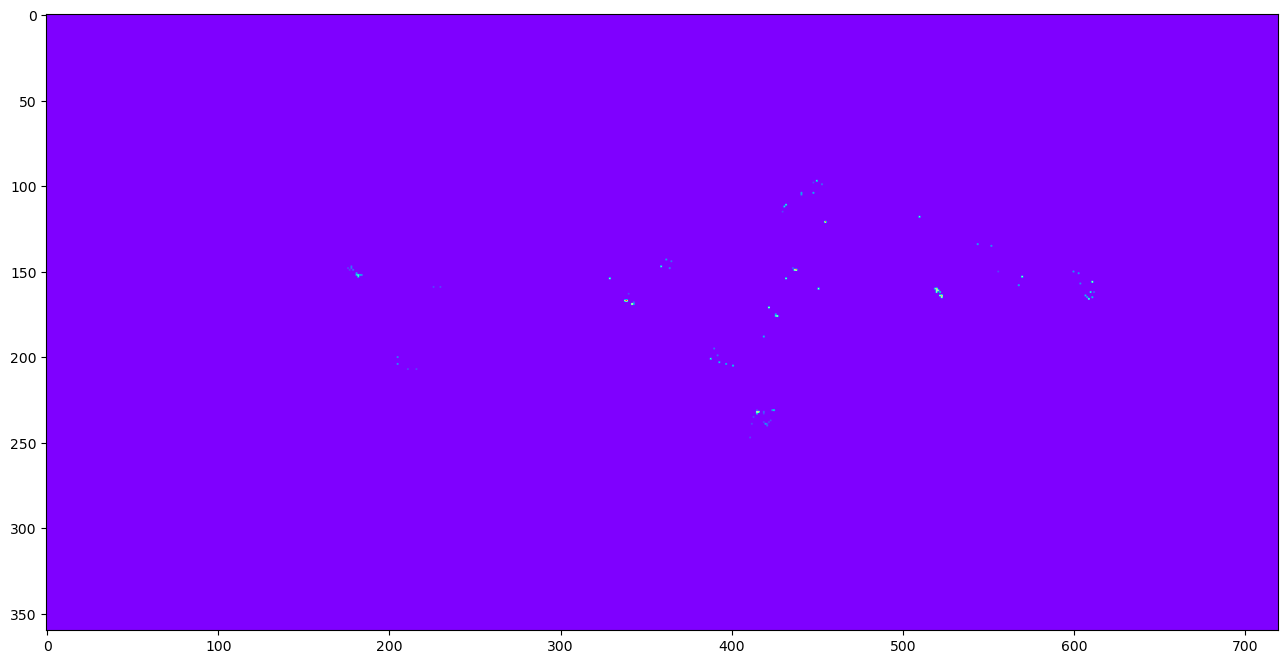

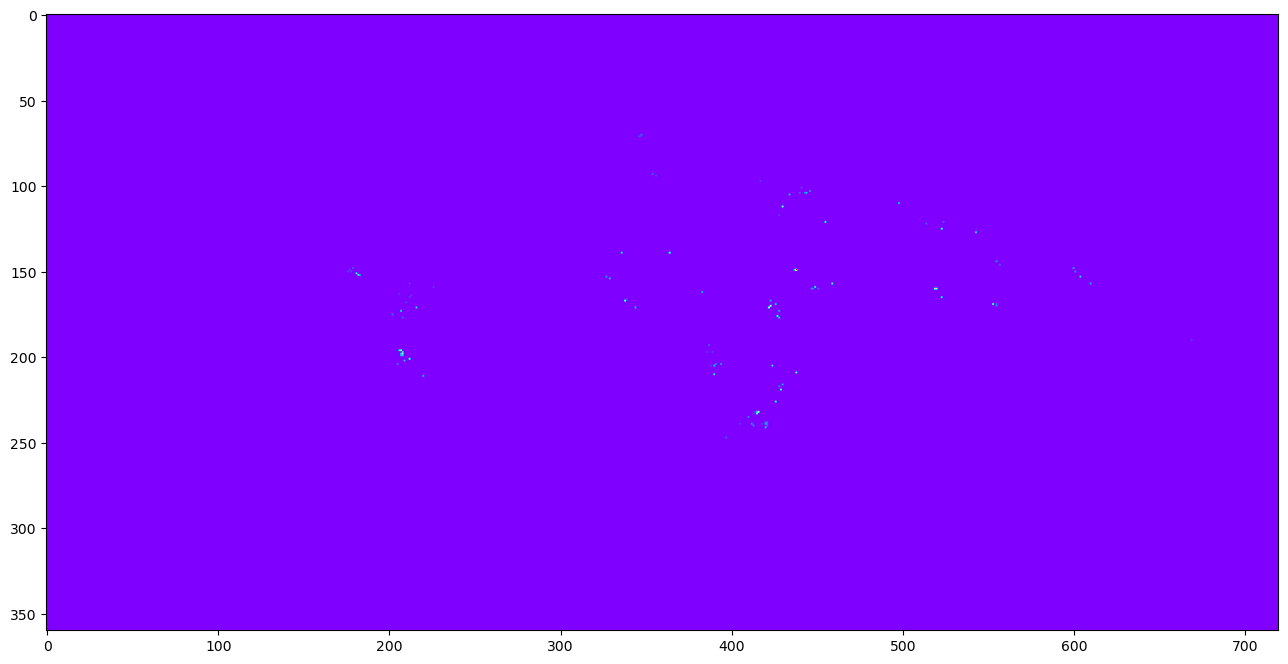

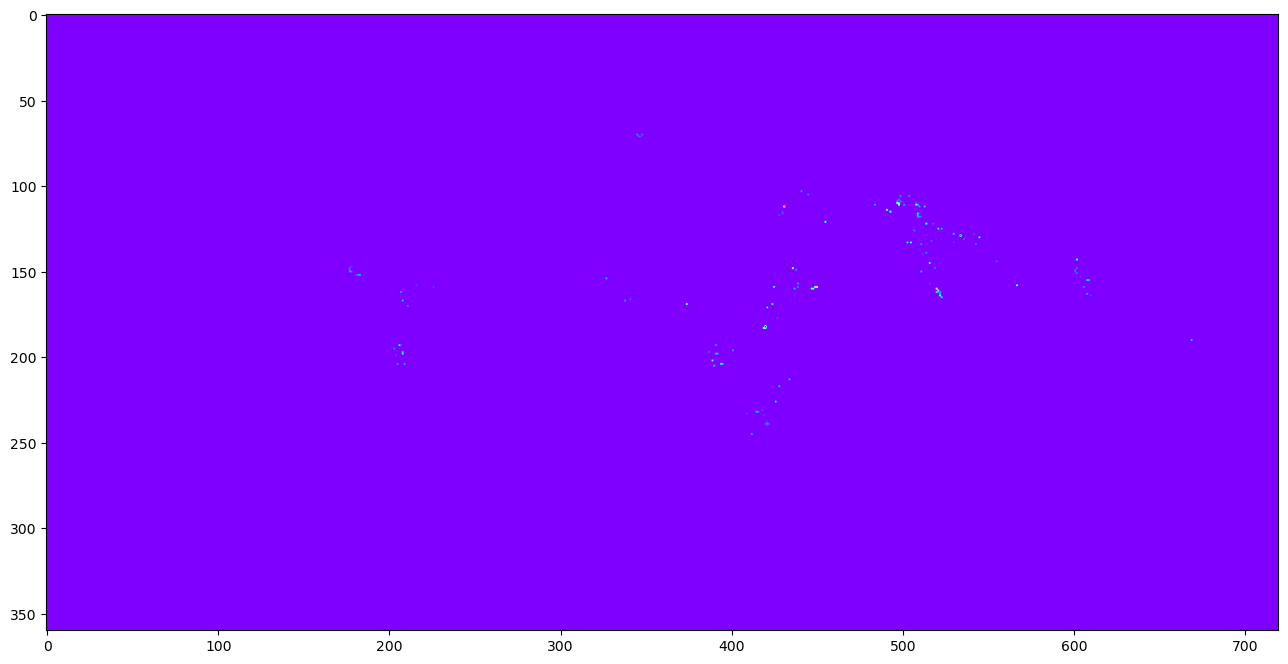

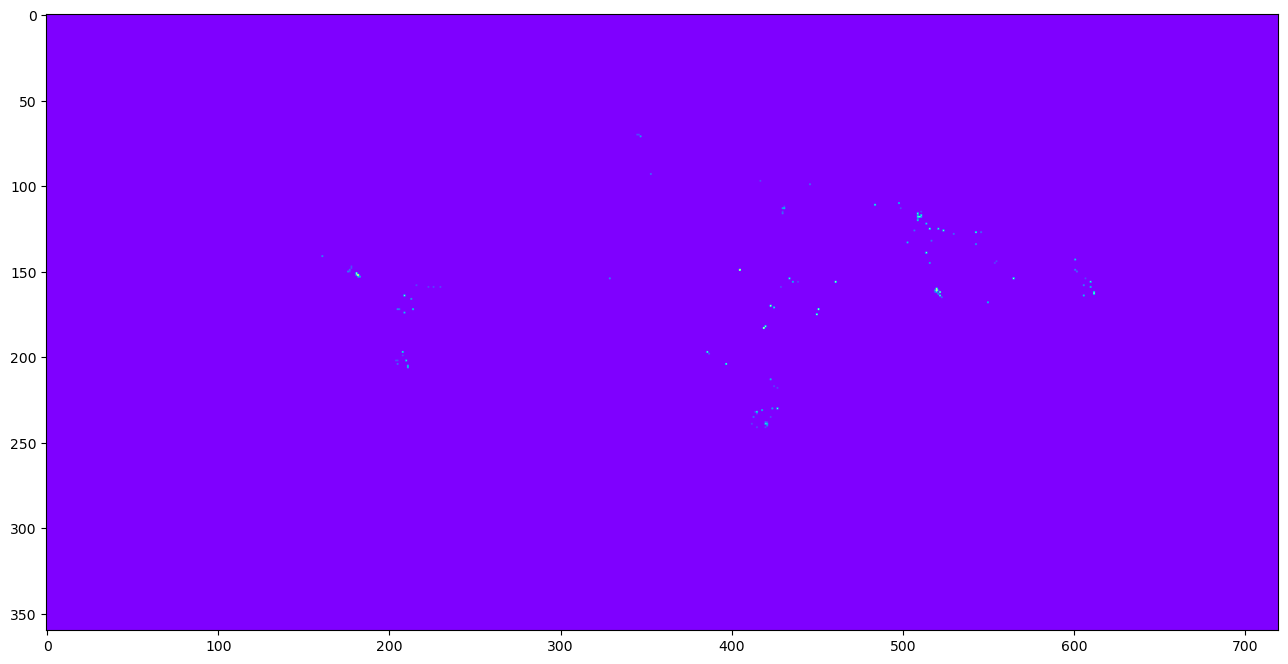

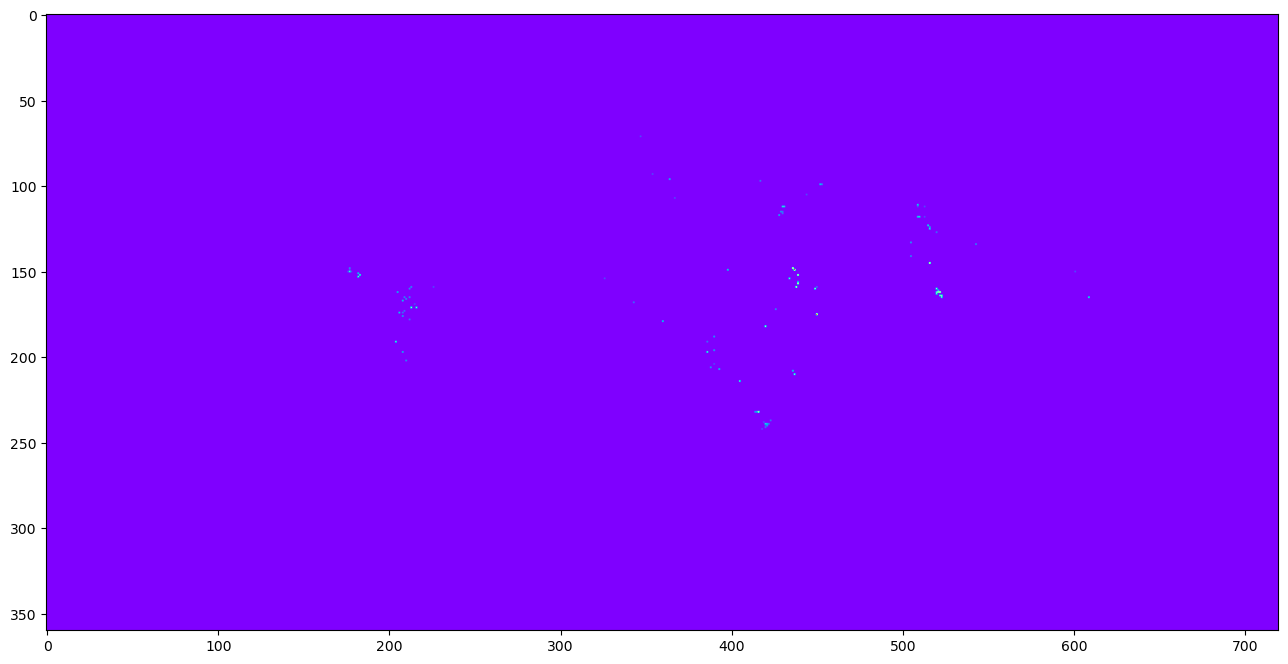

In [111]:
for i in range(ucpd_vol.shape[0]):

    plt.figure(figsize= [20,8])
    plt.imshow(ucpd_vol[i,:,:,7], cmap = 'rainbow', vmin=ucpd_vol[-1,:,:,7].min() , vmax=ucpd_vol[-1,:,:,7].max())
    plt.show()

In [103]:
x = np.arange(1,100,1)

x[-10:]

array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [105]:
y = np.array([x,x,x])

In [109]:
y.sum()

14850

In [107]:
y

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
        97, 98, 99],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
        97, 98, 99],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20

In [82]:
import  random

def draw_window(ucpd_vol, min_events): # yearly 10# try to set lower for monthly !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Should be in config....
# dim should be in some range and not fixed to 16..
# Make sure you do not go over the edge..

    #ucpd_vol_count = np.count_nonzero(ucpd_vol[:,:,:,4], axis = 0) # with coordinates in vol, log best is 7
    ucpd_vol_count = np.count_nonzero(ucpd_vol[:,:,:,7], axis = 0) # with coordinates in vol, log best is 7

    min_events_index = np.where(ucpd_vol_count >= min_events) # number of events so >= 1 or > 0 is the same as np.nonzero

    min_events_row = min_events_index[0]
    min_events_col = min_events_index[1]

    min_events_indx = [(row, col) for row, col in zip(min_events_row, min_events_col)] # is is index... Not lat long.
    
    indx = random.choice(min_events_indx)
    #dim = 16 # if truble, start by hard coding this to 16
    dim = np.random.choice([8, 16, 32, 64]) # 8, 64 # also do 128

    temporal_dim = np.random.choice([6, 12]) #, 24, 48, 96, 192]) 

    window_dict = {'lat_indx':indx[0], 'long_indx':indx[1], 'dim' : dim, 'temporal_dim': temporal_dim} # if you wnat a random temporal window, it is here.

    return(window_dict)

In [99]:
train_ucpd_vol = ucpd_vol[:-1] # all except the last year
#print(f'train data shape: {train_ucpd_vol.shape}') # debug.

# The lenght of a whole time lime.
seq_len = train_ucpd_vol.shape[0]

# ...
window_dict = draw_window(ucpd_vol = ucpd_vol, min_events = 2)

min_lat_indx = int(window_dict['lat_indx'] - (window_dict['dim']/2)) 
max_lat_indx = int(window_dict['lat_indx'] + (window_dict['dim']/2))
min_long_indx = int(window_dict['long_indx'] - (window_dict['dim']/2))
max_long_indx = int(window_dict['long_indx'] + (window_dict['dim']/2))

# if you want a fixe temporal window, this is here.
# It is now 7, not 4, since you keep coords.
#    input_window = train_ucpd_vol[ : , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx , 4].reshape(1, seq_len, window_dict['dim'], window_dict['dim'])
input_window = train_ucpd_vol[: , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 7].reshape(1, -1, window_dict['dim'], window_dict['dim']) 

In [100]:
# 0 since this is constant across years. 1 dim for batch and one dim for time.
gids = train_ucpd_vol[0 , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 0].reshape(1, 1, window_dict['dim'], window_dict['dim'])
longitudes = train_ucpd_vol[0 , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 1].reshape(1, 1, window_dict['dim'], window_dict['dim'])
latitudes = train_ucpd_vol[0 , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 2].reshape(1, 1, window_dict['dim'], window_dict['dim']) 

# gids_tensor = torch.tensor(gids, dtype=torch.int) # must be int. You don't use it any more.
# longitudes_tensor = torch.tensor(longitudes, dtype=torch.float)
# latitudes_tensor = torch.tensor(latitudes, dtype=torch.float)

# meta_tensor_dict = {'gids' : gids_tensor, 'longitudes' : longitudes_tensor, 'latitudes' : latitudes_tensor }
#input_tensor = torch.tensor(input_window).float()

In [102]:
input_window.shape

(1, 23, 16, 16)

In [98]:
for i in range(1000):
    min_temp_idx = 0
    max_temp_idx = train_ucpd_vol[:,:,:,:].shape[0] - window_dict['temporal_dim']

    start_temp = np.random.choice(np.arange(min_temp_idx, max_temp_idx+1, 1))
    end_temp = start_temp + window_dict['temporal_dim']

    if end_temp > train_ucpd_vol[:,:,:,:].shape[0]:
        print('shit')

In [97]:
train_ucpd_vol[:,:,:,:].shape[0]

23

In [94]:
print(f'{window_dict["temporal_dim"]}: {start_temp} - {end_temp}')

6: 15 - 21


In [85]:
print(min_temp_idx)
print(max_temp_idx)

0
17


In [71]:
input_window.shape

(1, 5, 16, 16)

In [19]:
ucpd_vol.shape

(24, 360, 720, 10)

In [15]:
ucpd_vol_count = np.count_nonzero(ucpd_vol[:,:,:,7], axis = 0) # with coordinates in vol, log best is 7

min_events_index = np.where(ucpd_vol_count >= 1)

In [ ]:
input_window = ucpd_vol[ : , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 7].reshape(1, seq_len, 32, 32) 

In [56]:
ucpd_vol.shape

(24, 360, 720, 10)

In [58]:
ucpd_vol[:,:,:,7].shape

(24, 360, 720)

In [ ]:
ucpd_vol

In [ ]:
range_ = 24
masK = (x > x.min() + range_/2) & (x < x.max() - range_/2)

In [54]:
for i in range(100000):

    range_ = 24
    mask = (x > x.min() + range_/2) & (x < x.max() - range_/2)

    d = np.random.choice(x[mask])

    d_array = np.arange(d-range_/2 , d+range_/2, 1)
    
    if d_array.max() > 99: 
        print('shit') 

    elif d_array.min() < 1:
        print('shit too')

    else:
        pass

In [ ]:
    range_ = 6
    mask = (x > x.min() + range_/2) & (x < x.max() - range_/2)

    d = np.random.choice(x[mask])

    d_array = np.arange(d-range_/2 , d+range_/2, 1)
    
    if d_array.max() > 99: 
        print('shit') 

    elif d_array.min() < 1:
        print('shit too')

    else:
        pass

In [44]:
mask = (x > x.min() + range_/2) & (x < x.max() - range_/2)

In [46]:
x[mask]

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95])

In [30]:
d - 1

5

In [20]:
ucpd_vol_count.shape

(360, 720)

In [16]:
min_events_index

(array([ 59,  69,  70, ..., 247, 247, 248]),
 array([560, 347, 344, ..., 399, 411, 397]))